In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

2024-03-14 11:43:03.200392: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-14 11:43:03.286275: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Training data 

In [2]:
def load_samples(path, change_order=False):

    root, _ = os.path.splitext(path)

    if change_order:
        X = np.load(f'{root}-data.npy').transpose(0, 2, 3, 1)   
    else:
        X = np.load(f'{root}-data.npy')
    Y = np.load(f'{root}-label.npy')
    return X, Y

In [3]:
sample_dir = f'../Sample/HVmodel/data/new/mix_sample_3.0_25x25_copy_1.npy'
print(f'Read data from {sample_dir}')
X, y = load_samples(sample_dir)

X, X_test, y, y_test = train_test_split(X, y, test_size=0.10, random_state=17)
X_train, _, y_train, _ = train_test_split(X, y, test_size=0.20, random_state=17)

Read data from ../Sample/HVmodel/data/new/mix_sample_3.0_25x25_copy_1.npy


In [4]:
sample_dir = f'../Sample/HVmodel/data/new/mix_sample_3.0_25x25.npy'
print(f'Read data from {sample_dir}')
_X, _y = load_samples(sample_dir)

_X, _, _y, _ = train_test_split(X, y, test_size=0.10, random_state=17)
_, X_val, _, y_val = train_test_split(X, y, test_size=0.20, random_state=17)

Read data from ../Sample/HVmodel/data/new/mix_sample_3.0_25x25.npy


In [6]:
def get_sample_size(y):
    if len(y.shape) == 1:
        ns = (y==1).sum()
        nb = (y==0).sum()
    else:
        ns = (y.argmax(axis=1)==1).sum()
        nb = (y.argmax(axis=1)==0).sum()
    print(ns, nb)
    return ns, nb

# Training 

## CNN

In [5]:
class CNN(tf.keras.Model):
    def __init__(self, name='CNN'):
        super(CNN, self).__init__(name=name)

        self.bn1 = tf.keras.layers.BatchNormalization()

        self.bn2 = tf.keras.layers.BatchNormalization()

        self.sub_network = tf.keras.Sequential([
            # tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(64, (5,5), padding='same', activation='relu'),
            tf.keras.layers.MaxPool2D((2,2)),
            tf.keras.layers.Conv2D(64, (5,5), padding='same', activation='relu'),
            tf.keras.layers.MaxPool2D((2,2)),
            tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
            tf.keras.layers.MaxPool2D((2,2)),
            tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid'),
        ])

    @tf.function
    def call(self, inputs, training=False):
        # split two channels
        channel1, channel2 = tf.split(inputs, num_or_size_splits=2, axis=-1)

        # pass through the same CNN
        channel1 = self.bn1(channel1)
        channel2 = self.bn2(channel2)
        output_channel1 = self.sub_network(channel1)
        output_channel2 = self.sub_network(channel2)

        # multiply the output
        output = tf.multiply(output_channel1, output_channel2)

        return output

In [7]:
class MyTestingCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_data):
        super(MyTestingCallback, self).__init__()
        self.test_data = test_data
        self.testing_loss = []
        self.testing_accuracy = []

    def on_epoch_end(self, epoch, logs=None):
        # Test on another dataset
        results = self.model.evaluate(x=self.test_data[0], y=self.test_data[1])
        self.testing_loss.append(results[0])
        # self.testing_accuracy.append(results[1])
        print(f'Testing Loss = {results[0]:.3}, Testing Accuracy = {results[1]:.3}')

        # Compute ACC
        y_pred = self.model.predict(self.test_data[0])
        ACC = get_highest_accuracy(self.test_data[1], y_pred)
        self.testing_accuracy.append(ACC)
        print(f'True ACC: Testing Loss = {results[0]:.3}, Testing Accuracy = {ACC:.3}')

def get_highest_accuracy(y_true, y_pred):
    _, _, thresholds = roc_curve(y_true, y_pred)
    # compute highest accuracy
    thresholds = np.array(thresholds)
    if len(thresholds) > 1000:
        thresholds = np.percentile(thresholds, np.linspace(0, 100, 1001))
    accuracy_scores = []
    for threshold in thresholds:
        accuracy_scores.append(accuracy_score(y_true, y_pred>threshold))

    accuracies = np.array(accuracy_scores)
    return accuracies.max()


class ROCCallback(tf.keras.callbacks.Callback):
    def __init__(self, testing_data):
        super(ROCCallback, self).__init__()
        self.testing_data = testing_data

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 == 0:
            val_loss = logs.get('val_loss')
            print(f'Validation loss at epoch {epoch}: {val_loss:.3f}')

            x_test, y_test = self.testing_data
            y_pred = self.model.predict(x_test)
            fpr, tpr, _ = roc_curve(y_test, y_pred)
            auc = roc_auc_score(y_test, y_pred)
            
            # plot ROC curve
            fig, ax = plt.subplots(1,1, figsize=(5,4))
            ax.plot(fpr, tpr, label=f'AUC = {auc:.3f}, Loss = {val_loss:.3f}')
            ax.plot([0, 1], [0, 1], 'k--')

            ax.axvline(x=0.1, color='grey', linestyle='--', linewidth=1)
            ax.axvline(x=0.01, color='grey', linestyle='--', linewidth=1)
            ax.axvline(x=0.001, color='grey', linestyle='--', linewidth=1)

            ax.set_xlabel('False Positive Rate')
            ax.set_ylabel('True Positive Rate')
            ax.set_title(f'ROC curve - Epoch {epoch+1}')
            ax.legend(frameon=False, fontsize=9)

            plt.savefig(f'./figures/HVmodel_roc_curve_ep{epoch+1}.pdf', dpi=300, facecolor='White', bbox_inches='tight')
            plt.close(fig)


class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [8]:
sample_dir = f'../Sample/HVmodel/data/new/mix_sample_testing_25x25.npy'
test_data = load_samples(sample_dir)

testing_callback = MyTestingCallback(test_data)
roc_callback = ROCCallback(test_data)
loss_history = LossHistory()

In [9]:
# Training parameters
batch_size = 512
train_epochs = 500
patience = 10
min_delta = 0.
learning_rate = 1e-4                                    
save_model_name = f'CNN_models/last_model_CNN/'

In [ ]:
# Create the model  
model = CNN()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=min_delta, verbose=1, patience=patience)
check_point    = tf.keras.callbacks.ModelCheckpoint(save_model_name, monitor='val_loss', verbose=1, save_best_only=True)

history = model.fit(x=X_train, y=y_train, validation_data=(X_val, y_val), epochs=train_epochs, batch_size=batch_size, callbacks=[early_stopping, check_point, testing_callback, roc_callback, loss_history])

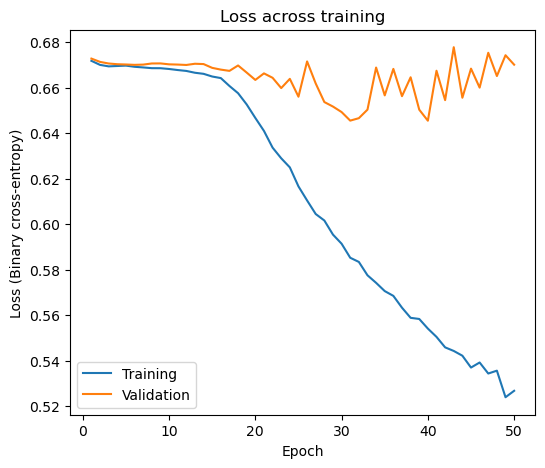

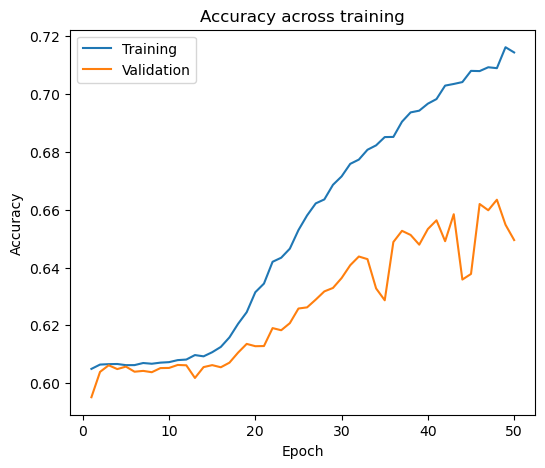

In [11]:
fig, ax = plt.subplots(1,1, figsize=(6,5))

x = range(1, len(history.history['loss']) + 1)
y_train = history.history['loss']
y_validation = history.history['val_loss']

ax.plot(x, y_train, label='Training')
ax.plot(x, y_validation, label='Validation')

ax.set_title('Loss across training')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss (Binary cross-entropy)')
ax.legend()

plt.show()

fig, ax = plt.subplots(1,1, figsize=(6,5))

x = range(1, len(history.history['accuracy']) + 1)
y_train = history.history['accuracy']
y_validation = history.history['val_accuracy']

ax.plot(x, y_train, label='Training')
ax.plot(x, y_validation, label='Validation')

ax.set_title('Accuracy across training')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()

plt.show()

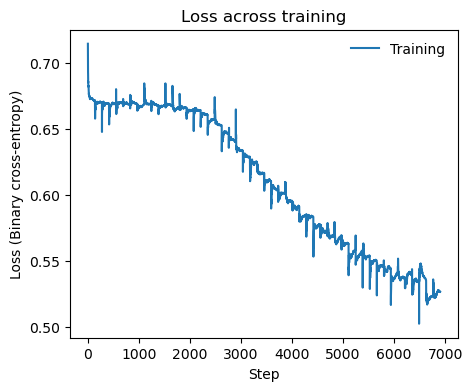

In [17]:
fig, ax = plt.subplots(1,1, figsize=(5,4))

x = range(1, len(loss_history.losses) + 1)
y_train = loss_history.losses
# y_validation = history.history['val_loss']

ax.plot(x, y_train, label='Training')
# ax.plot(x, y_validation, label='Validation')

ax.set_title('Loss across training')
# ax.set_xlim(1000, 3000)
ax.set_xlabel('Step')
ax.set_ylabel('Loss (Binary cross-entropy)')
ax.legend(frameon=False)

plt.show()

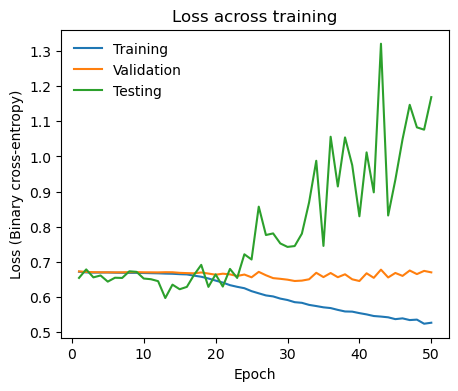

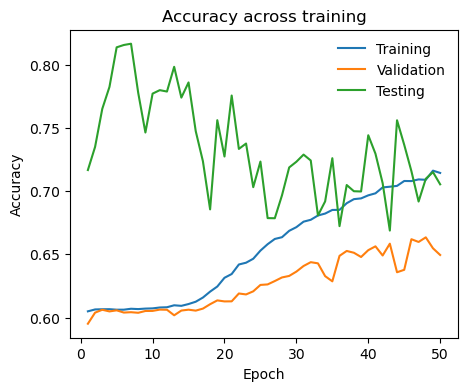

In [18]:
fig, ax = plt.subplots(1,1, figsize=(5,4))

x = range(1, len(history.history['loss']) + 1)
y_train = history.history['loss']
y_validation = history.history['val_loss']
y_testing = testing_callback.testing_loss

ax.plot(x, y_train, label='Training')
ax.plot(x, y_validation, label='Validation')
ax.plot(x, y_testing, label='Testing')

ax.set_title('Loss across training')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss (Binary cross-entropy)')
ax.legend(frameon=False,)

plt.savefig('../figures/HVmodel_loss_curve_copy_1_SB_3_res_25.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(1,1, figsize=(5,4))

x = range(1, len(history.history['accuracy']) + 1)
y_train = history.history['accuracy']
y_validation = history.history['val_accuracy']
y_testing = testing_callback.testing_accuracy

ax.plot(x, y_train, label='Training')
ax.plot(x, y_validation, label='Validation')
ax.plot(x, y_testing, label='Testing')

ax.set_title('Accuracy across training')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend(frameon=False,)

plt.savefig('../figures/HVmodel_acc_curve_copy_1_SB_3_res_25.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

# Training results

## Model

In [13]:
save_model_name = f'CNN_models/last_model_CNN/'
loaded_model = tf.keras.models.load_model(save_model_name)

In [7]:
save_model_name = f'./CNN_models/CNN_best_model_CWoLa_hunting_SB_1.0_copy_1_2_image/'
loaded_model = tf.keras.models.load_model(save_model_name)

## Testing data

In [7]:
sample_dir = f'../Sample/HVmodel/data/new/mix_sample_testing.npy'
X_test, y_test = load_samples(sample_dir)

results = loaded_model.evaluate(x=X_test, y=y_test)
print(f'Testing Loss = {results[0]:.3}, Testing Accuracy = {results[1]:.3}')

2024-03-12 11:54:18.151624: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401


 27/625 [>.............................] - ETA: 3s - loss: 0.7081 - accuracy: 0.5116

2024-03-12 11:54:19.659372: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


625/625 [==============================] - 7s 6ms/step - loss: 0.7140 - accuracy: 0.4982
Testing Loss = 0.714, Testing Accuracy = 0.498


## Signal score

In [4]:
sample_dir = f'../Sample/HVmodel/data/new/mix_sample_testing.npy'
X_test, y_test = load_samples(sample_dir)

313/313 [==============================] - 2s 5ms/step


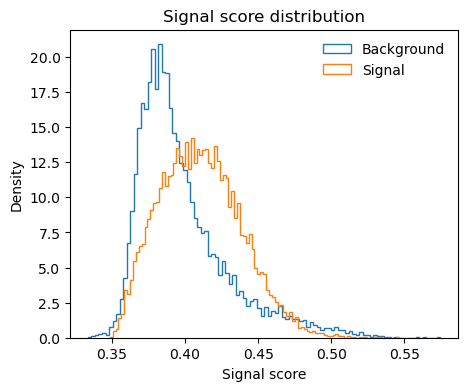

In [7]:
save_model_name = f'./CNN_models/CNN_best_model_CWoLa_hunting_SB_3.0_2_image/'
loaded_model = tf.keras.models.load_model(save_model_name)

fig, ax = plt.subplots(1,1, figsize=(5,4))

ax.hist(loaded_model.predict(X_test[y_test==0]), bins=100, histtype='step', label='Background', density=True)
ax.hist(loaded_model.predict(X_test[y_test==1]), bins=100, histtype='step', label='Signal', density=True)

ax.set_title('Signal score distribution')
ax.set_xlabel('Signal score')
ax.set_ylabel('Density')
ax.legend(frameon=False,)

plt.savefig('../figures/HVmodel_signal_score_origin_SB_3_res_75.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

313/313 [==============================] - 2s 5ms/step


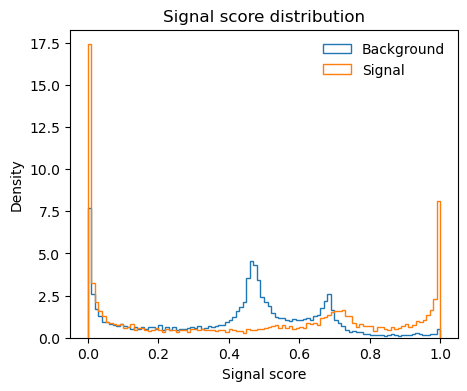

In [8]:
save_model_name = f'./CNN_models/CNN_best_model_CWoLa_hunting_SB_3.0_copy_1_2_image/'
loaded_model = tf.keras.models.load_model(save_model_name)

fig, ax = plt.subplots(1,1, figsize=(5,4))

ax.hist(loaded_model.predict(X_test[y_test==0]), bins=100, histtype='step', label='Background', density=True)
ax.hist(loaded_model.predict(X_test[y_test==1]), bins=100, histtype='step', label='Signal', density=True)

ax.set_title('Signal score distribution')
ax.set_xlabel('Signal score')
ax.set_ylabel('Density')
ax.legend(frameon=False,)

plt.savefig('../figures/HVmodel_signal_score_copy_1_SB_3_res_75.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

## Plot ROC

In [4]:
def plot_ROC_curve(model_path, X, y, model_name, **kwargs):
    loaded_model = tf.keras.models.load_model(model_path)
    y_pred = loaded_model.predict(X)
    fpr, tpr, thresholds = roc_curve(y, y_pred)
    auc = roc_auc_score(y, y_pred)

    acc = get_highest_accuracy(y, y_pred)
    # ax.plot(fpr, tpr, label=f'AUC = {auc:.3f}, ACC = {acc:.3f}, {model_name}', **kwargs)
    ax.plot(fpr, tpr, label=f'{model_name}', **kwargs)


In [5]:
sample_dir = f'../Sample/HVmodel/data/new/mix_sample_testing.npy'
X_test, y_test = load_samples(sample_dir)

625/625 [==============================] - 3s 5ms/step


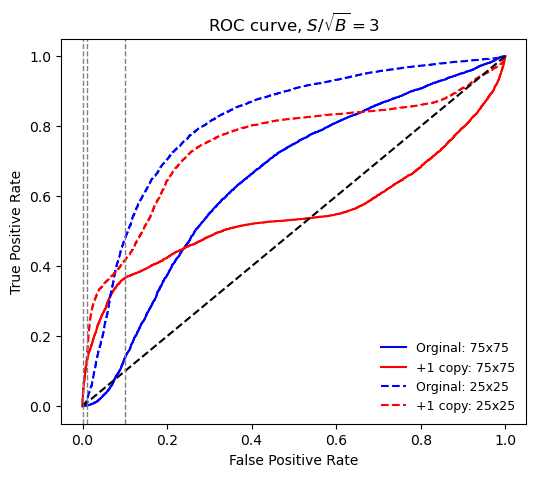

In [14]:
# Plot ROC curve
fig, ax = plt.subplots(1,1, figsize=(6,5))

i = 3
sample_dir = f'../Sample/HVmodel/data/new/mix_sample_testing.npy'
X_test, y_test = load_samples(sample_dir)
plot_ROC_curve(f'./CNN_models/CNN_best_model_CWoLa_hunting_SB_{i:.1f}_2_image/', X_test, y_test, f'Orginal: 75x75', color='b')
plot_ROC_curve(f'./CNN_models/CNN_best_model_CWoLa_hunting_SB_{i:.1f}_copy_1_2_image/', X_test, y_test, f'+1 copy: 75x75', color='r')

sample_dir = f'../Sample/HVmodel/data/new/mix_sample_testing_25x25.npy'
X_test, y_test = load_samples(sample_dir)
plot_ROC_curve(f'./CNN_models/CNN_best_model_CWoLa_hunting_SB_{i:.1f}_2_image_25x25/', X_test, y_test, f'Orginal: 25x25', linestyle='--', color='b')
plot_ROC_curve(f'./CNN_models/CNN_best_model_CWoLa_hunting_SB_{i:.1f}_copy_1_2_image_25x25/', X_test, y_test, f'+1 copy: 25x25', linestyle='--', color='r')

ax.plot([0, 1], [0, 1], 'k--')

ax.axvline(x=0.1, color='grey', linestyle='--', linewidth=1)
ax.axvline(x=0.01, color='grey', linestyle='--', linewidth=1)
ax.axvline(x=0.001, color='grey', linestyle='--', linewidth=1)

# log scale
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve, $S / \sqrt{B}=3$')
ax.legend(frameon=False, fontsize=9)

plt.savefig('../figures/HVmodel_roc_curve_origin_copy_1_SB_3_res_75_25.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()